## Setup

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from DynamicTimeWarping import DynamicTimeWarping

In [2]:
biotic_df = pd.read_excel('../data/PHYTO.xlsx', sheet_name='PHYTO_ONDATE')
biotic_columns = biotic_df.columns
biotic_df.head()


,LOC_CODE,DATUMTIJDWAARDE,Acn,Aco,Ata,Agl,Cfu,Ccu,Cda,Cdeb,...,Rst,Rte,Stu,Tni,Tec,Tle,Tno,Tro,Tor,Dat
0,DANTZGT,1990-04-04,NaN,NaN,NaN,3.271842,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.669596,3.572755,3.572755,NaN,4.475787,NaN,NaN
1,DANTZGT,1990-04-24,NaN,NaN,NaN,4.590418,NaN,NaN,NaN,NaN,...,NaN,NaN,2.448706,3.447933,NaN,NaN,NaN,3.447933,NaN,NaN
2,DANTZGT,1990-05-09,NaN,NaN,NaN,4.669596,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.012035,1.973128,NaN
3,DANTZGT,1990-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.590842,NaN,NaN
4,DANTZGT,1990-06-07,NaN,NaN,2.267172,5.300487,2.444045,NaN,NaN,NaN,...,NaN,NaN,NaN,3.566909,1.968483,3.442009,NaN,3.496376,1.968483,NaN


In [3]:
abiotic_df = pd.read_excel('../data/ABIO.xlsx', sheet_name='ABIO_AGGREGATED')
abiotic_df = abiotic_df.drop("AGG", axis=1)
abiotic_columns = abiotic_df.columns
abiotic_df.head()

,LOC_CODE,DATUMTIJDWAARDE,ZS,ZICHT,T,SiO2,SALNTT,PO4,pH,NO3,NO2,NH4,E,CHLFa
0,DANTZGT,1990-04-04,113.0,3.0,8.2,6.285714,28.79,0.806452,8.1,40.000000,2.000000,6.428571,NaN,25.0
1,DANTZGT,1990-06-02,295.0,0.5,6.0,NaN,27.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DANTZGT,1990-06-20,33.0,10.0,18.1,8.607143,32.69,1.451613,8.3,0.285714,0.142857,2.142857,NaN,6.2
3,DANTZGT,1990-07-18,39.0,4.0,17.0,6.071429,31.90,1.935484,8.2,0.357143,0.714286,4.285714,NaN,7.9
4,DANTZGT,1990-08-03,103.0,3.0,7.3,19.428571,24.99,0.709677,8.0,89.285714,2.071429,8.642857,NaN,21.1


---
## Helper Functions

In [4]:
def plot_inertia(input, nr_clusters_limit):
    inertia_list = []

    cluster_counts = range(1,nr_clusters_limit)

    for nr_clusters in cluster_counts:
        abiotic_kmeans = KMeans(n_clusters=nr_clusters, n_init='auto')
        abiotic_kmeans.fit(input)
        inertia_list.append(abiotic_kmeans.inertia_)

    fig = plt.figure(figsize=(6, 5))

    plt.plot(cluster_counts, inertia_list, marker='o')
    plt.xlabel('Nr Clusters')
    plt.ylabel('Kmean Inertia')

---

,LOC_CODE,DATUMTIJDWAARDE,ZS,T,SiO2,SALNTT,PO4,pH,NO3,NO2,NH4,E,CHLFa
0,DANTZGT,639187200000000000,1.686355,-0.835645,-0.416071,0.011711,-0.235756,0.151277,-0.012881,0.453272,0.121926,1.032773,1.973046
1,DANTZGT,644284800000000000,5.296363,-1.251005,-0.387593,-0.184643,-0.141799,0.530538,-0.285911,-0.005109,-0.051965,1.032773,0.976843
2,DANTZGT,645840000000000000,0.099539,1.033473,-0.359116,0.550995,-0.047843,0.909800,-0.558941,-0.463490,-0.225857,1.032773,-0.019360
3,DANTZGT,648259200000000000,0.218550,0.825793,-0.421328,0.441755,0.093092,0.530538,-0.557959,-0.181409,-0.051965,1.032773,0.160804
4,DANTZGT,649641600000000000,1.488003,-1.005565,-0.093620,-0.513745,-0.263943,-0.227985,0.664783,0.488532,0.301615,1.032773,1.559727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,WALCRN70,1597276800000000000,-0.475286,1.108993,-0.554777,0.870416,-0.302465,-0.227985,-0.557959,-0.516380,-0.385258,-0.706480,-0.594827
13607,WALCRN70,1600214400000000000,-0.465368,1.108993,-0.539005,0.842761,-0.415213,-0.341764,-0.531540,-0.477594,-0.360334,-0.729664,-0.520641
13608,WALCRN70,1602633600000000000,-0.456046,0.580354,-0.529016,0.856589,-0.410515,0.189203,-0.557959,-0.414126,-0.370188,-0.729664,-0.462353
13609,WALCRN70,1605571200000000000,-0.477269,0.240514,-0.481788,0.870416,-0.342866,0.265055,-0.474282,-0.117941,-0.385258,-0.729664,-0.507924


Pair (0, 0) done - 0%
Pair (0, 1) done - 0%
Pair (0, 2) done - 0%
Pair (0, 3) done - 0%
Pair (0, 4) done - 0%
Pair (0, 5) done - 0%
Pair (0, 6) done - 0%
Pair (0, 7) done - 0%
Pair (0, 8) done - 1%
Pair (0, 9) done - 1%
Pair (0, 10) done - 1%
Pair (0, 11) done - 1%
Pair (0, 12) done - 1%
Pair (0, 13) done - 1%
Pair (0, 14) done - 1%
Pair (0, 15) done - 2%
Pair (0, 16) done - 2%
Pair (0, 17) done - 2%
Pair (0, 18) done - 2%
Pair (0, 19) done - 2%
Pair (0, 20) done - 2%
Pair (0, 21) done - 2%
Pair (0, 22) done - 3%
Pair (0, 23) done - 3%
Pair (0, 24) done - 3%
Pair (0, 25) done - 3%
Pair (0, 26) done - 3%
Pair (1, 0) done - 3%
Pair (1, 1) done - 3%
Pair (1, 2) done - 3%
Pair (1, 3) done - 4%
Pair (1, 4) done - 4%
Pair (1, 5) done - 4%
Pair (1, 6) done - 4%
Pair (1, 7) done - 4%
Pair (1, 8) done - 4%
Pair (1, 9) done - 4%
Pair (1, 10) done - 5%
Pair (1, 11) done - 5%
Pair (1, 12) done - 5%
Pair (1, 13) done - 5%
Pair (1, 14) done - 5%
Pair (1, 15) done - 5%
Pair (1, 16) done - 5%
Pair (1,

/home/stephan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


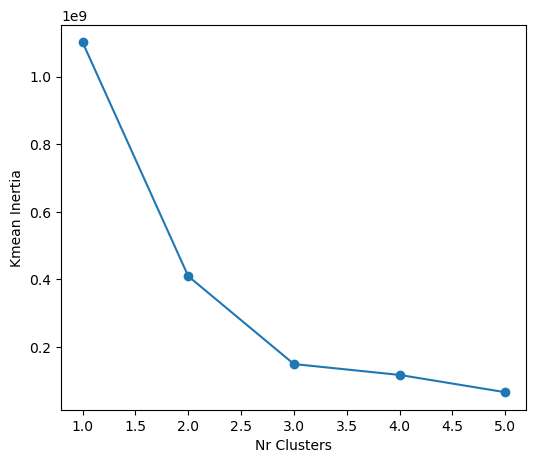

In [5]:
location_time_set = {"LOC_CODE", "DATUMTIJDWAARDE"}
parameter_columns = list(set(abiotic_columns) - location_time_set)

interpolated_abiotic_df = abiotic_df.groupby("LOC_CODE").apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(drop=True)

# we gotta normalize the values for the different variables prior to analysis
abio_data_scaler = StandardScaler()

abio_data_scaler.fit(interpolated_abiotic_df[parameter_columns])
normalized_data = abio_data_scaler.transform(interpolated_abiotic_df[parameter_columns])

# we normalized the values for all parameters
interpolated_abiotic_df[parameter_columns] = normalized_data

locations = interpolated_abiotic_df["LOC_CODE"].unique()

# ZICHT will be dropped since a lot of locations do not have a single recording of it
interpolated_abiotic_df = interpolated_abiotic_df.drop("ZICHT", axis=1)

interpolated_abiotic_df['DATUMTIJDWAARDE'] = interpolated_abiotic_df['DATUMTIJDWAARDE'].apply(lambda x: x.value)

display(interpolated_abiotic_df)

abiotic_data_tensor = []


for location in locations:
    single_location_df = interpolated_abiotic_df.loc[interpolated_abiotic_df["LOC_CODE"] == location].drop(["LOC_CODE", "DATUMTIJDWAARDE"], axis=1)

    abiotic_data_tensor.append(single_location_df.to_numpy())


DTW = DynamicTimeWarping()

similarity_matrix = DTW.similarity_matrix(abiotic_data_tensor)

plot_inertia(similarity_matrix, 6)

kmeans_model = KMeans(n_clusters = 3)
clusters = kmeans_model.fit_predict(similarity_matrix)
print(clusters)

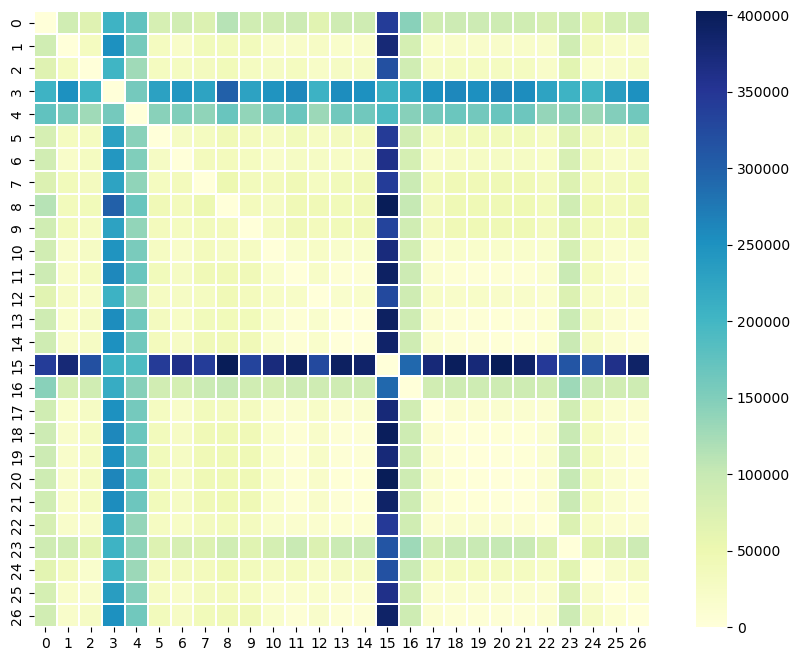

In [24]:
# DTW.plot_similarity_matrix(save=True)

fig, ax = plt.subplots(figsize=(12, 8))

ax = sns.heatmap(similarity_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)

fig.savefig(f"DTW_similarity_plot.png")

In [49]:
location_time_set = {"LOC_CODE", "DATUMTIJDWAARDE"}
parameter_columns = list(set(abiotic_columns) - location_time_set)

interpolated_abiotic_df = abiotic_df.groupby("LOC_CODE").apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(drop=True)

# we gotta normalize the values for the different variables prior to analysis
abio_data_scaler = StandardScaler()

abio_data_scaler.fit(interpolated_abiotic_df[parameter_columns])
normalized_data = abio_data_scaler.transform(interpolated_abiotic_df[parameter_columns])

# we normalized the values for all parameters
interpolated_abiotic_df[parameter_columns] = normalized_data

locations = list(interpolated_abiotic_df["LOC_CODE"].unique())

# ZICHT will be dropped since a lot of locations do not have a single recording of it
interpolated_abiotic_df = interpolated_abiotic_df.drop("ZICHT", axis=1)

interpolated_abiotic_df['DATUMTIJDWAARDE'] = interpolated_abiotic_df['DATUMTIJDWAARDE'].apply(lambda x: x.value)

display(interpolated_abiotic_df)

abiotic_data_tensor = []


for location in locations:
    single_location_df = interpolated_abiotic_df.loc[interpolated_abiotic_df["LOC_CODE"] == location].drop(["LOC_CODE", "DATUMTIJDWAARDE"], axis=1)

    abiotic_data_tensor.append(single_location_df.to_numpy())

,LOC_CODE,DATUMTIJDWAARDE,ZS,T,SiO2,SALNTT,PO4,pH,NO3,NO2,NH4,E,CHLFa
0,DANTZGT,639187200000000000,1.686355,-0.835645,-0.416071,0.011711,-0.235756,0.151277,-0.012881,0.453272,0.121926,1.032773,1.973046
1,DANTZGT,644284800000000000,5.296363,-1.251005,-0.387593,-0.184643,-0.141799,0.530538,-0.285911,-0.005109,-0.051965,1.032773,0.976843
2,DANTZGT,645840000000000000,0.099539,1.033473,-0.359116,0.550995,-0.047843,0.909800,-0.558941,-0.463490,-0.225857,1.032773,-0.019360
3,DANTZGT,648259200000000000,0.218550,0.825793,-0.421328,0.441755,0.093092,0.530538,-0.557959,-0.181409,-0.051965,1.032773,0.160804
4,DANTZGT,649641600000000000,1.488003,-1.005565,-0.093620,-0.513745,-0.263943,-0.227985,0.664783,0.488532,0.301615,1.032773,1.559727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,WALCRN70,1597276800000000000,-0.475286,1.108993,-0.554777,0.870416,-0.302465,-0.227985,-0.557959,-0.516380,-0.385258,-0.706480,-0.594827
13607,WALCRN70,1600214400000000000,-0.465368,1.108993,-0.539005,0.842761,-0.415213,-0.341764,-0.531540,-0.477594,-0.360334,-0.729664,-0.520641
13608,WALCRN70,1602633600000000000,-0.456046,0.580354,-0.529016,0.856589,-0.410515,0.189203,-0.557959,-0.414126,-0.370188,-0.729664,-0.462353
13609,WALCRN70,1605571200000000000,-0.477269,0.240514,-0.481788,0.870416,-0.342866,0.265055,-0.474282,-0.117941,-0.385258,-0.729664,-0.507924


In [50]:
from fastdtw import fastdtw


data = abiotic_data_tensor

# data.pop(15)
# locations.pop(15)
# data.pop(3)
# locations.pop(3)

# initialize the similarity matrix
similarity_matrix = np.zeros((len(data), len(data)))

distance_matrices = []
# checking similarity for all series pairs
for i, series1 in enumerate(data):
    for j, series2 in enumerate(data):
        distance, path = fastdtw(series1, series2)
        similarity_matrix[i, j] = distance
        print(f"Pair ({i}, {j}) done - {int((i * len(data) + j) / ((len(data))**2) * 100)}%")

Pair (0, 0) done - 0%
Pair (0, 1) done - 0%
Pair (0, 2) done - 0%
Pair (0, 3) done - 0%
Pair (0, 4) done - 0%
Pair (0, 5) done - 0%
Pair (0, 6) done - 0%
Pair (0, 7) done - 0%
Pair (0, 8) done - 1%
Pair (0, 9) done - 1%
Pair (0, 10) done - 1%
Pair (0, 11) done - 1%
Pair (0, 12) done - 1%
Pair (0, 13) done - 1%
Pair (0, 14) done - 1%
Pair (0, 15) done - 2%
Pair (0, 16) done - 2%
Pair (0, 17) done - 2%
Pair (0, 18) done - 2%
Pair (0, 19) done - 2%
Pair (0, 20) done - 2%
Pair (0, 21) done - 2%
Pair (0, 22) done - 3%
Pair (0, 23) done - 3%
Pair (0, 24) done - 3%
Pair (0, 25) done - 3%
Pair (0, 26) done - 3%
Pair (1, 0) done - 3%
Pair (1, 1) done - 3%
Pair (1, 2) done - 3%
Pair (1, 3) done - 4%
Pair (1, 4) done - 4%
Pair (1, 5) done - 4%
Pair (1, 6) done - 4%
Pair (1, 7) done - 4%
Pair (1, 8) done - 4%
Pair (1, 9) done - 4%
Pair (1, 10) done - 5%
Pair (1, 11) done - 5%
Pair (1, 12) done - 5%
Pair (1, 13) done - 5%
Pair (1, 14) done - 5%
Pair (1, 15) done - 5%
Pair (1, 16) done - 5%
Pair (1,

/tmp/ipykernel_198588/3880567767.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(similarity_matrix, method='single')


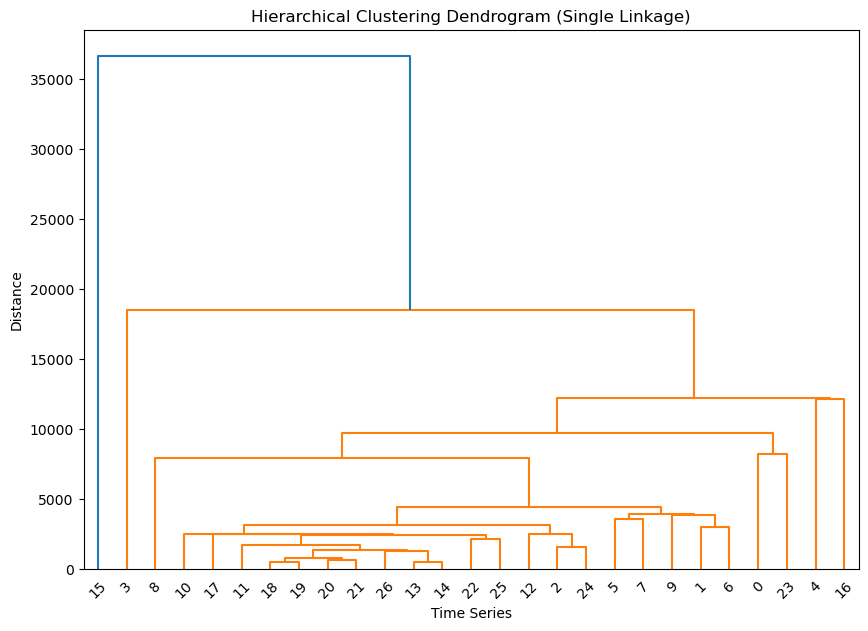

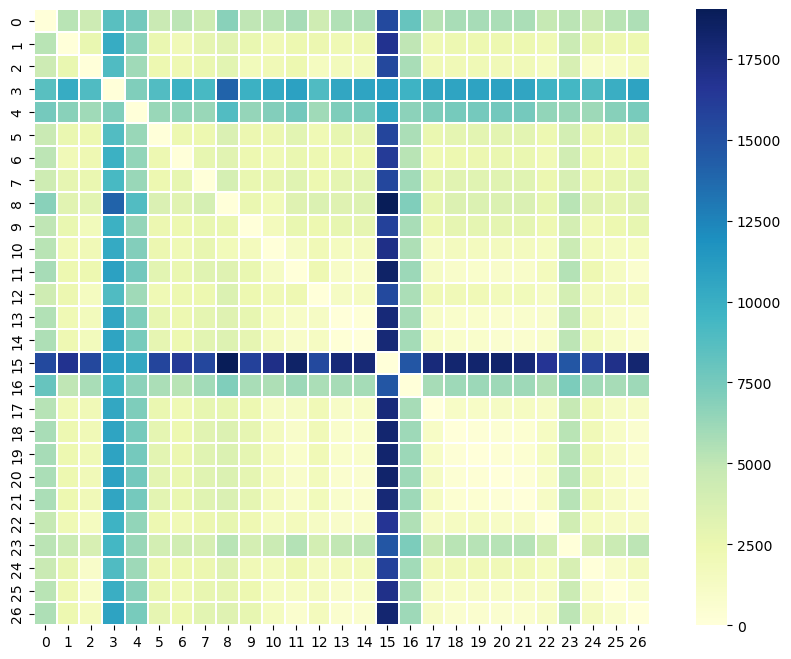

In [63]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering using the distance matrix
# Single-linkage clustering
linked = linkage(similarity_matrix, method='single')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=np.arange(len(data)))
plt.title('Hierarchical Clustering Dendrogram (Single Linkage)')
plt.xlabel('Time Series')
plt.ylabel('Distance')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax = sns.heatmap(similarity_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)

fig.savefig(f"DTW_similarity_plot.png")

In [73]:
kmeans_model = KMeans(n_clusters = 3)
clusters = kmeans_model.fit_predict(similarity_matrix)
print(clusters)

cluster_lists = [[], [], []]
for i, cluster in enumerate(clusters):
    print(i, locations[i], cluster)
    cluster_lists[cluster].append(locations[i])

[2 0 0 2 2 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 2 0 0 0]
0 DANTZGT 2
1 DREISR 0
2 GOERE6 0
3 GROOTGND 2
4 HANSWGL 2
5 HUIBGOT 0
6 LODSGT 0
7 MARSDND 0
8 NOORDWK10 0
9 NOORDWK2 0
10 NOORDWK20 0
11 NOORDWK70 0
12 ROTTMPT3 0
13 ROTTMPT50 0
14 ROTTMPT70 0
15 SCHAARVODDL 1
16 SOELKKPDOT 2
17 TERSLG10 0
18 TERSLG100 0
19 TERSLG135 0
20 TERSLG175 0
21 TERSLG235 0
22 TERSLG4 0
23 VLISSGBISSVH 2
24 WALCRN2 0
25 WALCRN20 0
26 WALCRN70 0


/home/stephan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [74]:
cluster_lists

[['DREISR',
  'GOERE6',
  'HUIBGOT',
  'LODSGT',
  'MARSDND',
  'NOORDWK10',
  'NOORDWK2',
  'NOORDWK20',
  'NOORDWK70',
  'ROTTMPT3',
  'ROTTMPT50',
  'ROTTMPT70',
  'TERSLG10',
  'TERSLG100',
  'TERSLG135',
  'TERSLG175',
  'TERSLG235',
  'TERSLG4',
  'WALCRN2',
  'WALCRN20',
  'WALCRN70'],
 ['SCHAARVODDL'],
 ['DANTZGT', 'GROOTGND', 'HANSWGL', 'SOELKKPDOT', 'VLISSGBISSVH']]

In [77]:
sil_score = silhouette_score(similarity_matrix, clusters)
db_index = davies_bouldin_score(similarity_matrix, clusters)
ch_score = calinski_harabasz_score(similarity_matrix, clusters)

print(f'Silhouette Score: {sil_score}')
print(f'Davies-Bouldin Index: {db_index}')
print(f'Calinski-Harabasz Index: {ch_score}')

Silhouette Score: 0.6350456091011134
Davies-Bouldin Index: 0.5101784722306862
Calinski-Harabasz Index: 76.35545375690496
